# Summary

Seasonality is a very important factor in time series analysis and the right tools can help to better understand how seasonality impacts the time series.

This notebook covers the usual issues you will face and steps you should take when you work on a new time series dataset. It covers how to:
1. Find duplicated rows
2. Find missing rows
3. Create seasonality features
4. Use Variance Inflation Factor to exclude features and reduce variance prediction
5. Hyper tune a Catboost model
6. Use Catboost to fill missing results
7. Use shap value to visualise how features impact energy consumption
8. Visualise seasonality using Seaborn

# Set environment

In [1]:
#data wrangling
import pandas as pd
import matplotlib.pyplot as plt

#plotting
import seaborn as sns
import numpy as np

# ML to estimate missing values
import catboost
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split

# modelfeature importance 
import shap
shap.initjs()

# multiple outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# The data

The data is the electric consumption for 10 years recorded by the American Electric Power and has been provided by Rob Mulla via Kaggle with other electricity consumption data: https://www.kaggle.com/robikscube/hourly-energy-consumption


In [2]:
df_url = 'https://raw.githubusercontent.com/charlesdethibault/my-library/master/datasets/american_electric_power_hourly.csv'
df = pd.read_csv(df_url)

The data:
* 1 index
* two columns, 1 with time, 1 with megawatt consumption
* there are 121273 rows
* Datetine is object type
* MW ( megawatt) is float

The plot below shows there is seasonality but it is difficult to have a clear view of it. Plus, we have not evaluated the data yet

Datetime     object
AEP_MW      float64
dtype: object

(121273, 2)

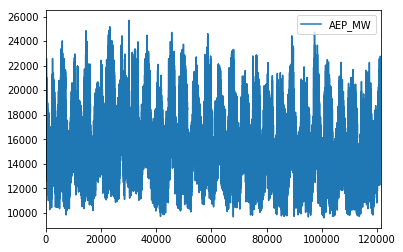

In [3]:
df.plot() # basic plot
df.dtypes # give data type
df.shape # give dataframe shape

# Quality check

When working with time series, the first action to be taken is to evaluate the quality of your time series by checking if there are duplicated values or missing values. After the missing values are identified we will use a Catboost Model to estimate the missing values

In [4]:
# sort dates, extract start, extract end, set date as index
quality_check = df.set_index('Datetime').sort_index()
print('data starts at '+ str(quality_check.index[0]))
print('data finishes at '+ str(quality_check.index[-1]))
print('___')
print('   ')
# find duplicates
print('duplicates:')
quality_check[quality_check.index.duplicated()]
# remove duplicates by keeping the first occurence
quality_check = quality_check.loc[~quality_check.index.duplicated(keep='first')]
no_dupe_len = len(quality_check)
print('length of dataframe without duplicates is '+ str(no_dupe_len))
print('___')
print('   ')
# find if missing rows by creating date_range and merging it to the data
date_range = pd.DataFrame(pd.date_range(start='2004-10-01', end='2018-08-03',freq='1h'))
date_range.columns = ['Datetime']
date_range = date_range.set_index('Datetime')
quality_check = date_range.merge(quality_check,how='outer' ,left_index=True, right_index=True)
# print missing rows
print('missing rows:')
quality_check[quality_check.isnull().any(axis=1)]
# change initial dataframe
df = quality_check
df = df.reset_index(inplace=False)

data starts at 2004-10-01 01:00:00
data finishes at 2018-08-03 00:00:00
___
   
duplicates:


,AEP_MW
Datetime,
2014-11-02 02:00:00,13190.0
2015-11-01 02:00:00,10542.0
2016-11-06 02:00:00,11008.0
2017-11-05 02:00:00,10446.0


length of dataframe without duplicates is 121269
___
   
missing rows:


,AEP_MW
Datetime,
2004-10-01 00:00:00,NaN
2004-10-31 02:00:00,NaN
2005-04-03 03:00:00,NaN
2005-10-30 02:00:00,NaN
2006-04-02 03:00:00,NaN
2006-10-29 02:00:00,NaN
2007-03-11 03:00:00,NaN
2007-11-04 02:00:00,NaN
2008-03-09 03:00:00,NaN


# Seasonality feature creation

Extract date, hour, day of week month, season, and year.

* df['Datetime'].dt.weekday give the day of week digit, 
* df['Datetime'].dt.weekday_name the day of week name

With regards to day of week and seasons, for optimisation it is better to work with a digit than the name itself. For visualisation, it is the opposite. The digit will be replaced later on by the name when we will visualise the seasonality.

* DOW = Day of Week
* DOM = Day of Month
* DOY = Day of Year
* WOY = Week of Year

In [5]:
# creating seasonality features as columns
df['date'] = df['Datetime'].dt.date
df['hour'] = df['Datetime'].dt.hour
df['dow_digit'] = df['Datetime'].dt.weekday # day of week
df['dom'] = df['Datetime'].dt.day # day of month
df['doy'] = df['Datetime'].dt.dayofyear
df['woy'] = df['Datetime'].dt.weekofyear
df['month'] = df['Datetime'].dt.month
df['quarter'] = df['Datetime'].dt.quarter
season = [4, 4, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4]
month_to_season = dict(zip(range(1,13), season))
df['season'] = df['Datetime'].dt.month.map(month_to_season) 

df['year'] = df['Datetime'].dt.year
df.head(1)
df.tail(1)
df.dtypes



,Datetime,AEP_MW,date,hour,dow_digit,dom,doy,woy,month,quarter,season,year
0,2004-10-01,NaN,2004-10-01,0,4,1,275,40,10,4,3,2004


,Datetime,AEP_MW,date,hour,dow_digit,dom,doy,woy,month,quarter,season,year
121296,2018-08-03,14809.0,2018-08-03,0,4,3,215,31,8,3,2,2018


Datetime     datetime64[ns]
AEP_MW              float64
date                 object
hour                  int64
dow_digit             int64
dom                   int64
doy                   int64
woy                   int64
month                 int64
quarter               int64
season                int64
year                  int64
dtype: object

# Multicolinearity Analysis and Variance Inflation Factor

In statistics, the variance inflation factor (VIF) is the quotient of the variance in a model with multiple terms by the variance of a model with one term alone. It quantifies the severity of multicollinearity in an ordinary least squares regression analysis.The square root of the variance inflation factor indicates how much larger the standard error increases compared to if that variable had 0 correlation to other predictor variables in the model (Wikipedia).

High VIF should be avoided because this means that the two factors bring the same information and increase variance in data prediction. **A common mistake is to fit a maximum of features hoping to improve the prediction. This is a mistake as too many features can create overfitting and prediction variance.** Variance above 10 is considered high. The factors should be taken one by one from the highest.

VIF analysis suggests to remove day of year, month and quarter.

The below steps should be coded into a function and a library as VIF equivalent fron R does not seem to exist in Python

In [6]:
# VIF step 1
df_vif = df
df_cor = df_vif.corr()
pd.Series(np.linalg.inv(df.corr().values).diagonal(), index=df_cor.index)

AEP_MW           1.585023
hour             1.278840
dow_digit        1.076303
dom            322.905106
doy          46646.466237
woy             19.065755
month        46137.050738
quarter         18.086022
season           2.687867
year             1.061233
dtype: float64

In [7]:
# VIF step 2
df_vif = df_vif.drop(['doy'], axis=1)
df_cor = df_vif.corr()
pd.Series(np.linalg.inv(df_vif.corr().values).diagonal(), index=df_cor.index)

AEP_MW        1.574349
hour          1.276962
dow_digit     1.075736
dom           1.063850
woy          19.064375
month        33.714260
quarter      18.085589
season        1.195710
year          1.061230
dtype: float64

In [8]:
# VIF step 3
df_vif = df_vif.drop(['month'], axis=1)
df_cor = df_vif.corr()
pd.Series(np.linalg.inv(df_vif.corr().values).diagonal(), index=df_cor.index)

AEP_MW        1.571642
hour          1.276485
dow_digit     1.075593
dom           1.032517
woy          10.083778
quarter      10.109063
season        1.192116
year          1.061221
dtype: float64

In [9]:
# VIF step 3
df_vif = df_vif.drop(['quarter'], axis=1)
df_cor = df_vif.corr()
pd.Series(np.linalg.inv(df_vif.corr().values).diagonal(), index=df_cor.index)

AEP_MW       1.560881
hour         1.274593
dow_digit    1.075188
dom          1.005542
woy          1.126088
season       1.187611
year         1.060040
dtype: float64

In [10]:
# update dataframe
df = df_vif
df.columns

Index(['Datetime', 'AEP_MW', 'date', 'hour', 'dow_digit', 'dom', 'woy',
       'season', 'year'],
      dtype='object')

# missing value filling with Catboost

The scatter plot shows acceptable prediction fit using Catboost to predict energy consumption.

The feature importance list the features as such:
1. week of year
2. season
3. day of week
4. year
5. hour
6. day of month

The first shap value chart shows that the feature hour is positively correlated with energy consumption while year and day of week are inversively correlated. This means that more energy is consumed during the evening, the consumption has decreased over the year and that there is less energy consumption at the end of the week. The shap signal on other features are less obvious.

The second shap value chart shows a lower consumption during low hours ( morning) and a high consumption during high hours ( evening) but also shows that this relationship changes with the season. In winter, the difference between low hours and high hours is lower as the shap value shows there is a higher consumption is winter in the morning than summer but also that there is a lower consumption in winter in the evening than in summer.

The third shap value chart shows that while the consumption is lower during the weekend, the energy is not consumed equally during every day. Sunday shows most of its consumption during the evening. 


In [11]:
# replace nans with catboost
# columns that should be categories
categorical = ['hour'
               ,'dow_digit'
               ,'dom'
               ,'season'
               ,'year'
               ,'woy']
# create target df
non_na = df.dropna()
X = non_na.drop(['AEP_MW','Datetime','date'], axis=1)
y = non_na['AEP_MW']
X_target = df[df.isnull().any(axis=1)].drop(['AEP_MW','Datetime','date'], axis=1)
y_target = df[df.isnull().any(axis=1)]['AEP_MW']
#

def column_index(dfcat, query_cols):
    cols = dfcat.columns.values
    sidx = np.argsort(cols)
    return sidx[np.searchsorted(cols, query_cols, sorter=sidx)]
categorical_features_indices = column_index(X, categorical)


# set hyperparameter testing
# split data for training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
# set hyper parameter model
HP_model = CatBoostRegressor(iterations=1000)
train_pool = Pool(X_train, y_train, cat_features=categorical)
test_pool = Pool(X_test, cat_features=categorical)
grid = {'learning_rate': [0.05,0.1,0.2,0.3,0.4,0.5]
        ,'depth':[4,6,8,10,12]
        ,'l2_leaf_reg': [1, 3, 5, 7]
        }
grid_search_results = HP_model.grid_search(grid, train_pool, shuffle=False, verbose=3, plot=True)
grid_search_results['params']

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	loss: 897.0301726	best: 897.0301726 (0)	total: 19.5s	remaining: 38m 36s
3:	loss: 789.4947436	best: 789.4947436 (3)	total: 1m 7s	remaining: 32m 32s
6:	loss: 898.5323464	best: 760.5449070 (5)	total: 1m 55s	remaining: 30m 57s
9:	loss: 796.4227757	best: 760.5449070 (5)	total: 2m 41s	remaining: 29m 33s
12:	loss: 902.5127301	best: 760.5449070 (5)	total: 3m 26s	remaining: 28m 20s
15:	loss: 795.5437486	best: 760.5449070 (5)	total: 4m 12s	remaining: 27m 23s
18:	loss: 902.1852921	best: 760.5449070 (5)	total: 4m 59s	remaining: 26m 31s
21:	loss: 797.4063193	best: 760.5449070 (5)	total: 5m 44s	remaining: 25m 34s
24:	loss: 817.6910679	best: 760.5449070 (5)	total: 6m 38s	remaining: 25m 12s
27:	loss: 674.0067354	best: 674.0067354 (27)	total: 7m 47s	remaining: 25m 36s
30:	loss: 826.1657853	best: 653.6063732 (29)	total: 8m 55s	remaining: 25m 38s
33:	loss: 685.1272433	best: 653.6063732 (29)	total: 10m 3s	remaining: 25m 27s
36:	loss: 830.9335619	best: 652.9360820 (35)	total: 11m 11s	remaining: 25m 5s
3

{'depth': 12, 'l2_leaf_reg': 1, 'learning_rate': 0.1}

In [12]:
model=CatBoostRegressor(iterations=1000
                        , depth=10
                        , l2_leaf_reg =  1
                        , learning_rate=0.2
                        , loss_function='RMSE')
model.fit(X_train, y_train,cat_features=categorical_features_indices,eval_set=(X_test, y_test),plot=True,logging_level='Silent');

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

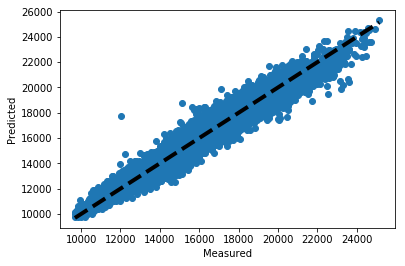

In [13]:
y_pred = model.predict(X_test)
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured');
ax.set_ylabel('Predicted');
plt.show();

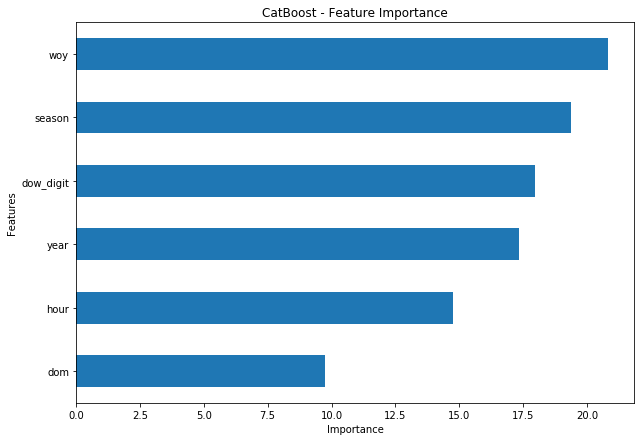

In [14]:
#find feature importance
fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': X.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
fea_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 7), legend=None)
plt.title('CatBoost - Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance');

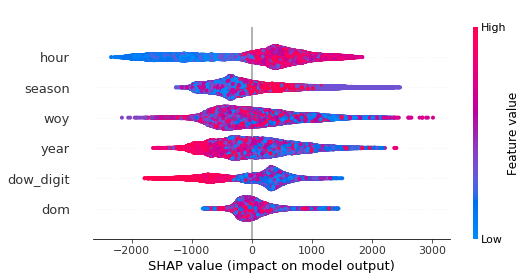

In [15]:
# find shap values
shap_values = model.get_feature_importance(Pool(X_train
                                                , y_train
                                               ,cat_features=categorical_features_indices)
                                               , type='ShapValues')

expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

shap.summary_plot(shap_values, X_train)

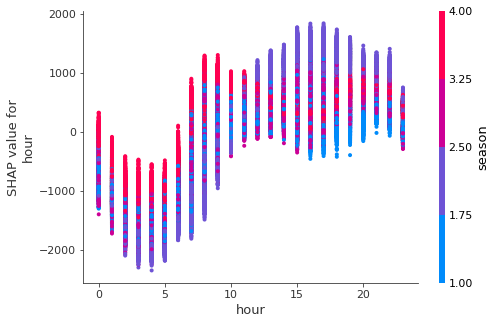

In [16]:
shap.dependence_plot("hour", shap_values, X_train)

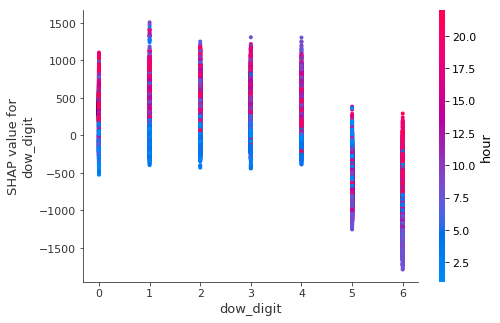

In [17]:
shap.dependence_plot("dow_digit", shap_values, X_train)

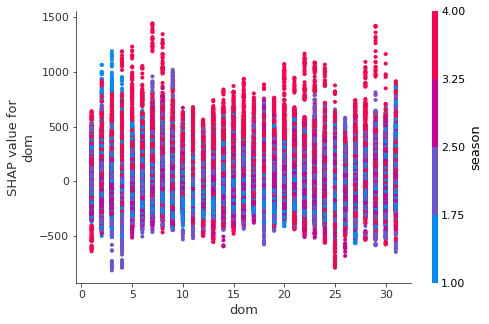

In [18]:
shap.dependence_plot("dom", shap_values, X_train)

# Fill missing data and change category digit to names

In [19]:
X_target = df[df.isnull().any(axis=1)].drop(['AEP_MW','Datetime','date'], axis=1)
X_target['AEP_MW'] = model.predict(X_target)
X_target = X_target['AEP_MW']
new_df = df.merge(X_target,how='outer' ,left_index=True, right_index=True)
new_df.AEP_MW_x.fillna(new_df.AEP_MW_y, inplace=True)
new_df = new_df.drop(['AEP_MW_y','dow_digit'], axis=1).rename(columns={"AEP_MW_x": "AEP_MW"})
mapping = {1: 'Spring', 2: 'Summer', 3: 'Automn',4:'Winter'}
new_df = new_df.replace({'season': mapping})
new_df['dow_name'] = new_df['Datetime'].dt.weekday_name
df = new_df

# filter data for clarity

In [20]:
mask = (df['Datetime'] >= '2013-01-01') & (df['Datetime'] <= '2017-12-31')
df = df.loc[mask]
df.head(1)
df.tail(1)

,Datetime,AEP_MW,date,hour,dom,woy,season,year,dow_name
72336,2013-01-01,14734.0,2013-01-01,0,1,1,Winter,2013,Tuesday


,Datetime,AEP_MW,date,hour,dom,woy,season,year,dow_name
116136,2017-12-31,17761.0,2017-12-31,0,31,52,Winter,2017,Sunday


# Seasonality

The model with shap values have predicted what can be visualised on the charts below:
* the consumption is going down over the years
* depending on the seasons the hourly change can be very different
* there is a much lower consumption during the weekend

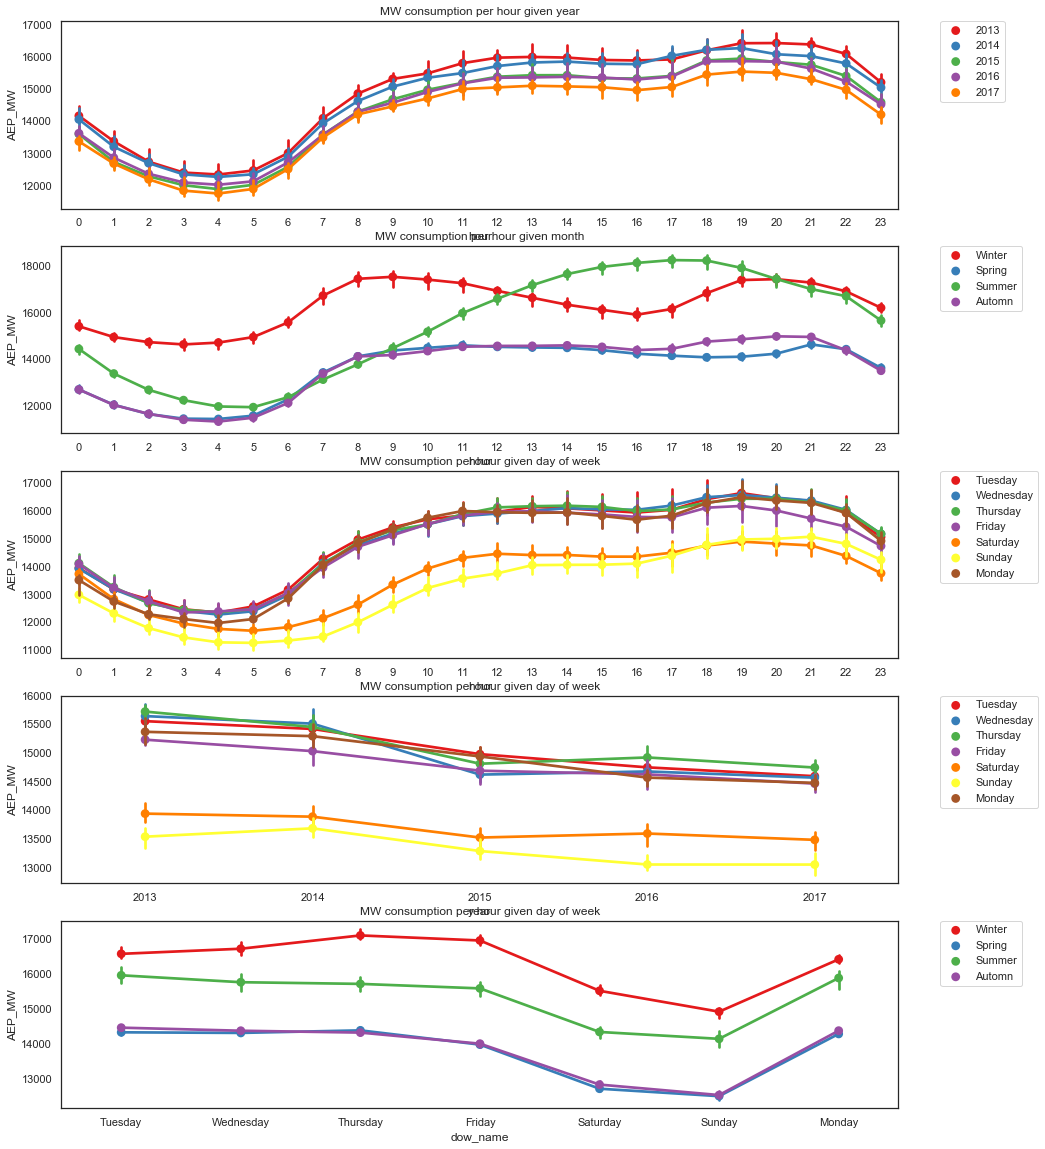

In [23]:
sns.set(style="white")
f,axes = plt.subplots(5,1,figsize=(15,20),sharex=False)
ax1 = sns.pointplot(x="hour", y="AEP_MW",hue="year",estimator=np.median, data=df,ax=axes[0],palette=("Set1"))
ax1.set_title("MW consumption per hour given year")
ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax2 = sns.pointplot(x="hour", y="AEP_MW",hue="season",estimator=np.median, data=df,ax=axes[1],palette=("Set1"))
ax2.set_title("MW consumption per hour given month")
ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax3 = sns.pointplot(x="hour", y="AEP_MW",hue="dow_name",estimator=np.median, data=df,ax=axes[2],palette=("Set1"));
ax3.set_title("MW consumption per hour given day of week");
ax3.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
ax4 = sns.pointplot(x="year", y="AEP_MW",hue="dow_name",estimator=np.median, data=df,ax=axes[3],palette=("Set1"));
ax4.set_title("MW consumption per hour given day of week");
ax4.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
ax5 = sns.pointplot(x="dow_name", y="AEP_MW",hue="season",estimator=np.median, data=df,ax=axes[4],palette=("Set1"));
ax5.set_title("MW consumption per hour given day of week");
ax5.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);